# Reinforcement Learning Individual Assignment - Marius DRAGIC

## Imports

In [1]:
import gymnasium as gym
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import text_flappy_bird_gym
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import gymnasium as gym
import random 
import os
import random
import torch
from itertools import product

from tqdm.notebook import tqdm

## Agents

### Monte Carlo Agent

In [2]:
class MonteCarloAgent:
    """
    Monte Carlo Agent with epsilon-greedy exploration.
    """
    
    def __init__(self, 
                 env, 
                 gamma=0.95, 
                 epsilon=1.0, 
                 epsilon_decay=0.99, 
                 epsilon_min=0.001, 
                 n_game_validation=50, 
                 validate_model=True):
        """
        Initialize the Monte Carlo agent.
        
        :param env: Gym environment.
        :param gamma: Discount factor.
        :param epsilon: Initial exploration rate.
        :param epsilon_decay: Exponential decay rate of epsilon.
        :param epsilon_min: Minimum epsilon value.
        :param n_game_validation: Number of validation games before saving the model.
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.actions = list(range(env.action_space.n))
        self.Q = {}
        self.returns = {}
        self.best_avg_score = float("-inf")
        self.n_game_validation = n_game_validation
        self.validate_model = validate_model
        os.makedirs("models", exist_ok=True)

    def get_epsilon_greedy_action(self, state):
        """
        Select an action based on the epsilon-greedy policy.
        """
        if state not in self.Q:
            self.Q[state] = {a: 0.0 for a in self.actions}
        return random.choice(self.actions) if random.random() < self.epsilon else max(self.Q[state], key=self.Q[state].get)

    def generate_episode(self):
        """
        Play an entire episode and return the sequence of (state, action, reward).
        """
        episode = []
        state, info = self.env.reset()
        done = False
        while not done:
            action = self.get_epsilon_greedy_action(state)
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def update_Q(self, episode):
        """
        Update the Q-table using Monte Carlo First-Visit.
        """
        G = 0.0
        visited = set()
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = self.gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                if s not in self.Q:
                    self.Q[s] = {act: 0.0 for act in self.actions}
                if (s, a) not in self.returns:
                    self.returns[(s, a)] = []
                self.returns[(s, a)].append(G)
                self.Q[s][a] = np.mean(self.returns[(s, a)])

    def save_model(self, verbose=False):
        """
        Save the current model as the best model.
        """
        torch.save({"Q": self.Q, "best_avg_score": self.best_avg_score}, "models/best_mc_agent.pth")
        if verbose:
            print(f"New best model saved! Validated average score: {self.best_avg_score:.2f}")

    def train(self, num_episodes=1000, verbose=False):
        """
        Train the agent.
        """
        scores = []
        for i in tqdm(range(1, num_episodes + 1), desc="Training"):
            episode = self.generate_episode()
            episode_return = sum([step[2] for step in episode])
            scores.append(episode_return)
            self.update_Q(episode)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if self.validate_model:
                if episode_return > self.best_avg_score:
                    if verbose:
                        print(f"[Episode {i}] New high score detected: {episode_return}")
                    avg_validation_score = self.evaluate(self.n_game_validation, verbose=verbose)
                    if avg_validation_score > self.best_avg_score:
                        self.best_avg_score = avg_validation_score
                        self.save_model()

            else:
                if len(scores) >= 50:
                    best_50_score = 0
                    mean_50_score = np.mean(scores[-50:])

                    
                    if mean_50_score > best_50_score:
                        best_50_score = mean_50_score
                        if verbose:
                            print(f"[Episode {i}] New best avg score over last 50 episodes: {best_50_score}")
                        
                        self.save_model()

        return scores


    def load_best_model(self, filepath="models/best_mc_agent.pth"):
        """
        Load the best saved model containing the optimal Q-table and best validated average score.
        """
        if not os.path.exists(filepath):
            print(f"No model found at {filepath}.")
            return
        checkpoint = torch.load(filepath)
        self.Q = checkpoint["Q"]
        self.best_avg_score = checkpoint["best_avg_score"]
        print(f"Model loaded! Best validated average score: {self.best_avg_score:.2f}")

    def evaluate(self, num_episodes=10, render=False, max_score=10000, verbose=False):
        """
        Evaluate the loaded model over a number of episodes and return the average score.
        """
        total_scores = []
        old_epsilon = self.epsilon
        self.epsilon = 0.0
        for ep in range(num_episodes):
            state, info = self.env.reset()
            done = False
            score = 0
            while not done:
                action = random.choice(self.actions) if state not in self.Q else max(self.Q[state], key=self.Q[state].get)
                next_state, reward, done, _, _ = self.env.step(action)
                score += reward
                state = next_state
                if score >= max_score:
                    total_scores.append(score)
                    if verbose:
                        print(f"Victory! Score greater than {max_score}!")
                    break

                if render:
                    print(self.env.render())
            total_scores.append(score)
        self.epsilon = old_epsilon
        avg_score = np.mean(total_scores)
        if verbose:
            print(f"Average evaluation score over {num_episodes} episodes (Monte-Carlo): {avg_score:.2f}")
        return avg_score

### SARSA Agent

In [3]:
class SarsaAgent:
    """
    SARSA Agent with eligibility traces and validation-based model saving.
    """

    def __init__(self, 
                 env, 
                 gamma=0.99, 
                 alpha=0.1, 
                 lambda_=0.9,
                 epsilon=1.0, 
                 epsilon_decay=0.995, 
                 epsilon_min=0.001, 
                 n_game_validation=50,
                 validate_model=True):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.validate_model = validate_model
        self.actions = list(range(env.action_space.n))
        self.Q = {}
        self.best_avg_score = float("-inf")
        self.n_game_validation = n_game_validation
        os.makedirs("models", exist_ok=True)

    def get_epsilon_greedy_action(self, state):
        if state not in self.Q:
            self.Q[state] = {a: 0.0 for a in self.actions}
        return random.choice(self.actions) if random.random() < self.epsilon else max(self.Q[state], key=self.Q[state].get)

    def save_model(self, verbose=False):
        torch.save({"Q": self.Q, "best_avg_score": self.best_avg_score}, "models/best_sarsa_agent.pth")
        if verbose:
            print(f"New best SARSA model saved. Validated average score: {self.best_avg_score:.2f}")

    def load_best_model(self, filepath="models/best_sarsa_agent.pth"):
        if not os.path.exists(filepath):
            print(f"No model found at {filepath}.")
            return
        checkpoint = torch.load(filepath)
        self.Q = checkpoint["Q"]
        self.best_avg_score = checkpoint["best_avg_score"]
        print(f"SARSA model loaded. Best validated average score: {self.best_avg_score:.2f}")

    def train(self, num_episodes=1000, verbose=False):
        scores = []
        for i in tqdm(range(1, num_episodes + 1), desc="Training SARSA"):
            state, info = self.env.reset()
            action = self.get_epsilon_greedy_action(state)
            e = {}
            done = False
            episode_return = 0

            while not done:
                next_state, reward, done, _, _ = self.env.step(action)
                episode_return += reward

                if not done:
                    next_action = self.get_epsilon_greedy_action(next_state)
                else:
                    next_action = None

                if next_state not in self.Q:
                    self.Q[next_state] = {a: 0.0 for a in self.actions}

                current_Q = self.Q[state][action]
                next_Q = 0 if next_action is None else self.Q[next_state][next_action]
                delta = reward + self.gamma * next_Q - current_Q

                if state not in e:
                    e[state] = {a: 0.0 for a in self.actions}
                e[state][action] += 1

                for s_x in e:
                    for a_x in e[s_x]:
                        self.Q[s_x][a_x] += self.alpha * delta * e[s_x][a_x]
                        e[s_x][a_x] *= self.gamma * self.lambda_

                state = next_state
                action = next_action

            scores.append(episode_return)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if self.validate_model:
                if episode_return > self.best_avg_score:
                    if verbose:
                        print(f"[Episode {i}] New high score detected: {episode_return}")
                    avg_validation_score = self.evaluate(self.n_game_validation, verbose=verbose)
                    if avg_validation_score > self.best_avg_score:
                        self.best_avg_score = avg_validation_score
                        self.save_model()

            else:
                if len(scores) >= 50:
                    best_50_score = 0
                    mean_50_score = np.mean(scores[-50:])

                    
                    if mean_50_score > best_50_score:
                        best_50_score = mean_50_score
                        if verbose:
                            print(f"[Episode {i}] New best avg score over last 50 episodes: {best_50_score}")
                        
                        self.save_model()

        return scores

    def evaluate(self, num_episodes=10, render=False, max_score=10000, verbose=False):
        total_scores = []
        old_epsilon = self.epsilon
        self.epsilon = 0.0

        for ep in range(num_episodes):
            state, info = self.env.reset()
            done = False
            score = 0

            while not done:
                action = random.choice(self.actions) if state not in self.Q else max(self.Q[state], key=self.Q[state].get)
                next_state, reward, done, _, _ = self.env.step(action)
                score += reward
                state = next_state

                if score >= max_score:
                    total_scores.append(score)
                    if verbose:
                        print(f"Victory! Score reached {max_score} or more.")
                    break

                if render:
                    print(self.env.render())

            total_scores.append(score)

        self.epsilon = old_epsilon
        avg_score = np.mean(total_scores)
        if verbose:
            print(f"Average score over {num_episodes} episodes (SARSA): {avg_score:.2f}")
        return avg_score

## Utils

Lists some basic functions used for experimental reproducibility and used in plot functions.

In [4]:
def set_seed(seed):
    """
    Set the seed for reproducibility, used for generating same TFB games to better compare agents.
    """
    random.seed(seed)
    np.random.seed(seed)


def display_hyperparameters_agents(agent):
    """
    Display the hyperparameters of the agent.
    """
    attributes = vars(agent)
    gamma = attributes["gamma"]
    eps = attributes["epsilon_decay"]
    print(f"Gamma : {gamma}, Espilon decay : {eps}")

def centered_moving_average(data, window):
    pad = window // 2
    extended = np.pad(data, (pad, pad - (1 - window % 2)), mode='edge')
    return np.convolve(extended, np.ones(window)/window, mode='valid')


## Plotting functions

Lists all the plotting functions used in this notebook

In [5]:
def plot_score_evolution(scores, window=70):

    scores = np.array(scores)
    x = np.arange(len(scores))
    cmap = plt.get_cmap("tab10")
    color_raw = cmap(0)
    color_mean = cmap(1)

    smooth = centered_moving_average(scores, window)

    std = np.std(scores[-30:])
    upper = smooth + std
    lower = np.maximum(smooth - std, 0)

    plt.figure(figsize=(12, 6))

    plt.plot(x, scores, label="One shot socre", color=color_raw, alpha=0.2)
    plt.plot(x, smooth, label=f"Moving average (window={window})", color=color_mean, linewidth=2.2)

    plt.fill_between(x, lower, upper, color=color_mean, alpha=0.2, 
                     label="± Standard deviation 30 last score")
    
    plt.title("Évolution du score Flappy Bird", fontsize=14, fontweight="bold")
    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_state_value(agent):

    dx_max = 20
    dy_min, dy_max = -10, 10
    dy_size = dy_max - dy_min

    value_map = np.zeros((dx_max, dy_size))

    for dx in range(dx_max):
        for idx_dy in range(dy_size):
            dy = idx_dy + dy_min
            s = (dx, dy)
            value_map[dx, idx_dy] = max(agent.Q[s].values()) if s in agent.Q else 0

    extent = [0, dx_max, dy_min, dy_max]
   
    plt.figure(figsize=(8, 6))
    plt.imshow(value_map.T, origin='lower', aspect='auto', cmap='plasma', extent=extent)
    plt.colorbar(label="V(s) = max_a Q(s, a)")
    plt.xlabel("dx")
    plt.ylabel("dy")
    plt.title("State-Value Function Heatmap")
    plt.show()


def plot_state_action(agent):

    dx_max = 20
    dy_min, dy_max = -10, 10
    dy_size = dy_max - dy_min

    value_map = np.zeros((dx_max, dy_size))
    action_map = np.zeros((dx_max, dy_size))  

    for dx in range(dx_max):
        for idx_dy in range(dy_size):
            dy = idx_dy + dy_min
            s = (dx, dy)
            if s in agent.Q:
                best_action = max(agent.Q[s], key=agent.Q[s].get)  
                action_map[dx, idx_dy] = best_action 
                value_map[dx, idx_dy] = agent.Q[s][best_action]  


    dx_range = range(dx_max)
    dy_range = range(dy_min, dy_max)
    X, Y = np.meshgrid(dx_range, dy_range)
    Z = value_map.T
    action_colors = action_map.T

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.bwr(action_colors), edgecolor='k', linewidth=0.5)

    ax.set_xlabel("dx (Horizonal Distance)")
    ax.set_ylabel("dy (Vertical Distance)")
    ax.set_zlabel("V(s) = max_a Q(s, a)")
    ax.set_title("State-Value Function with Action Coloring")

    color_bar = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
    color_bar.set_array([0, 1])
    cbar = plt.colorbar(color_bar, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label("Action (0 = Fall, 1 = Flap)")

    plt.show()

def plot_avg_score(env, agent_class, name_agent, num_episodes=4000, num_runs=10, verbose=False):

    all_scores = []  

    for run in tqdm(range(num_runs), desc="Runs"):
        agent = agent_class(env, validate_model=False) 
        scores = agent.train(num_episodes, verbose=verbose)
        all_scores.append(scores)

    all_scores = np.array(all_scores)  

    mean_scores = np.mean(all_scores, axis=0)
    std_scores = np.std(all_scores, axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(mean_scores, label="Mean Score", color="blue")
    plt.fill_between(range(num_episodes),
                     np.maximum(mean_scores - std_scores, 0),
                     mean_scores + std_scores,
                     color="blue", alpha=0.2, label="Standard Deviation")

    plt.xlabel("Episodes")
    plt.ylabel(f"Mean score")
    plt.title(f"Mean score agent over {num_runs} runs in function of steps for {name_agent} agent")
    plt.legend()
    plt.grid()
    plt.show()

def plot_scores_by_gamma(env, 
                         agent_class, 
                         gamma_values=[0.9, 0.95, 0.99], 
                         num_episodes=1000, 
                         smoothing_window=50):
    
    plt.figure(figsize=(12, 6))
    colors = plt.get_cmap("tab10")

    def moving_average(values, window=50):

        return np.convolve(values, np.ones(window)/window, mode='valid')

    for idx, gamma in enumerate(gamma_values):


        agent = agent_class(env=env,
                            gamma=gamma, 
                            validate_model=False)
        display_hyperparameters_agents(agent)
    
        scores = agent.train(num_episodes=num_episodes, verbose=False)
        
        smoothed_scores = moving_average(scores, smoothing_window)

        plt.plot(range(len(smoothed_scores)), smoothed_scores, 
                 label=f"γ = {gamma}", 
                 color=colors(idx), 
                 linewidth=2)

        std_dev = np.std(scores[-100:]) 
        plt.fill_between(range(len(smoothed_scores)), 
                         np.maximum(smoothed_scores - std_dev, 0), 
                         smoothed_scores + std_dev, 
                         color=colors(idx), 
                         alpha=0.2)

    plt.title(f"Score Evolution by Gamma - {agent_class.__name__}", fontsize=14, fontweight="bold")
    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel("Smoothed Score", fontsize=12)
    plt.legend(title="Gamma Values")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


def plot_scores_by_eps_decay(env, 
                         agent_class, 
                         eps_decay_values=[0.98, 0.99, 0.995, 0.997, 0.999],
                         num_episodes=1000, 
                         smoothing_window=50):
    
    plt.figure(figsize=(12, 6))
    colors = plt.get_cmap("tab10")    

    for idx, eps in enumerate(eps_decay_values):


        agent = agent_class(env=env, 
                            epsilon_decay=eps,
                            validate_model=False)
        display_hyperparameters_agents(agent)

        def moving_average(values, window=50):

            return np.convolve(values, np.ones(window)/window, mode='valid')
    
        scores = agent.train(num_episodes=num_episodes, verbose=False)
        smoothed_scores = moving_average(scores, smoothing_window)

        plt.plot(range(len(smoothed_scores)), smoothed_scores, 
                 label=f"eps = {eps}", 
                 color=colors(idx), 
                 linewidth=2)

        std_dev = np.std(scores[-100:])  
        plt.fill_between(range(len(smoothed_scores)), 
                         np.maximum(smoothed_scores - std_dev, 0), 
                         smoothed_scores + std_dev, 
                         color=colors(idx), 
                         alpha=0.2)

    plt.title(f"Score Evolution by Epsilon Decay - {agent_class.__name__}", fontsize=14, fontweight="bold")
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Smoothed Score", fontsize=12)
    plt.legend(title="Gamma Values")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    
def plot_scores_by_env_configs(agent_class, configs, num_episodes=500, n_runs=3):

    means = []
    stds = []
    labels = []

    SEED = 42
    set_seed(SEED)

    for idx, config in enumerate(configs):
        env = gym.make("TextFlappyBird-v0", 
                       height=config["height"], 
                       width=config["width"], 
                       pipe_gap=config["pipe_gap"])
        env.reset(seed=SEED)
        
        run_scores = []
        for _ in range(n_runs):
            agent = agent_class(env)
            scores = agent.train(num_episodes)
            mean_score = np.mean(scores[-100:])
            run_scores.append(mean_score)

        mean = np.mean(run_scores)
        std = np.std(run_scores)
        means.append(mean)
        stds.append(std)

        label = f"pg={config['pipe_gap']}, h={config['height']}, w={config['width']}"
        labels.append(label)

    plt.figure(figsize=(12, 6))
    x = np.arange(len(configs))
    colors = plt.get_cmap("tab10")

    bars = plt.bar(x, means, yerr=stds, capsize=8,
                   color=[colors(i % 10) for i in range(len(configs))],
                   edgecolor='black')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + stds[i] + 5,
                 f"{means[i]:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(x, labels, rotation=30, ha='right')
    plt.xlabel("Environment Configuration", fontsize=12)
    plt.ylabel("Mean Score (last 100 episodes)", fontsize=12)
    plt.title(f"Agent Performance across Environment Configs ({agent_class.__name__})", fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return list(zip(labels, means, stds))

## Instanciations

In [6]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

Here we instantiate the environment common to the 2 agents SARSA and MonteCarlo, the aim being to compare the performance of the 2 agents on a common environment in order to draw conclusions.

## Training Monte-Carlo Agent

First we train our agent with an improved epsilon greedy strategy, we set an espilon decay so that the more an agent learns, the more it exploits and the less it explores. To limitate the time taken during training we only train our agents on 1000 steps. Once the training is done we set epsilon to 0 and we look performances of our best agent model saved.

In [8]:
agent_mc = MonteCarloAgent(env, validate_model=True)
scores_mc = agent_mc.train(num_episodes=1000, verbose=False)
agent_mc.load_best_model('./models/best_mc_agent.pth')
agent_mc.evaluate(100, verbose=True)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_18189/3087512931.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


Model loaded! Best validated average score: 10000.00
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Victory! Score greater than 10000!
Vi

np.float64(9949.8391959799)

The agent performs perfectly, we choose to stop the game when the agent reach 10000 score. Thus Monte Carlo agent manages to win all 100 games by achieving a score of over 10,000. Evaluating the agent over 100 games ensures that our agent is robust and doesn't just perform on one game because it's been lucky.

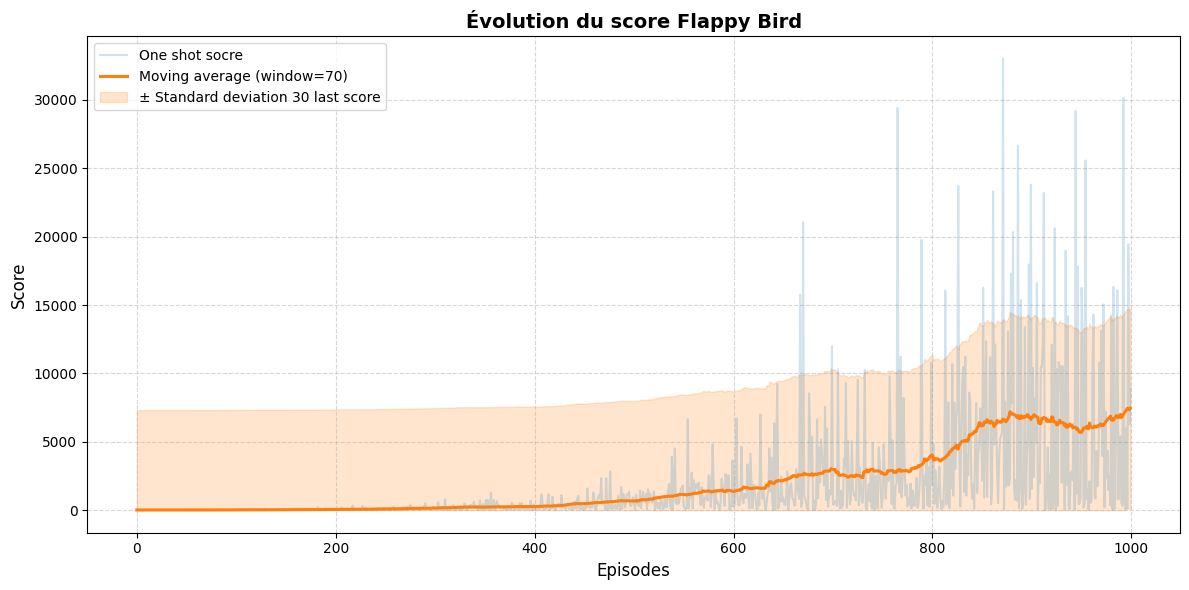

In [9]:
plot_score_evolution(scores_mc)

## Training Sarsa Agent

In [ ]:
agent_sarsa = SarsaAgent(env)
scores_sarsa = agent_sarsa.train(1000, verbose=False)
agent_sarsa.load_best_model('./models/best_sarsa_agent.pth')
agent_sarsa.evaluate(100, verbose=True)

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_15010/1160496083.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


SARSA model loaded. Best validated average score: 8484.45
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 or more.
Victory! Score reached 10000 o

np.float64(8825.95061728395)

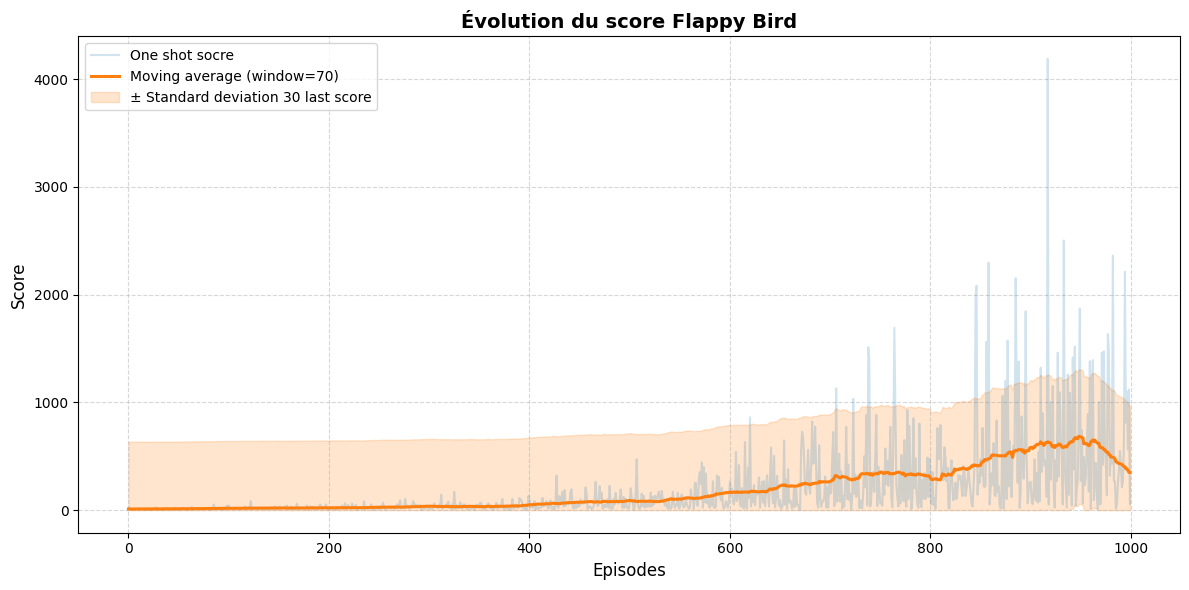

In [ ]:
plot_score_evolution(scores_sarsa)

Agent SARSA is clearly less effective than Agent MonteCarlo, but his performance in just 1000 episodes is still largely acceptable.

## Averaged score and standard deviation per agent

### Monte Carlo averaged score over 20 runs

Each training session produces agents whose performance varies, mainly due to the randomness of the games, which can either prevent or help the agent to learn better. In order to be more accurate in our analysis, we display the score curves obtained on average after 20 training sessions, together with the standard deviation, to visualize the variability of scores after training.

Runs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

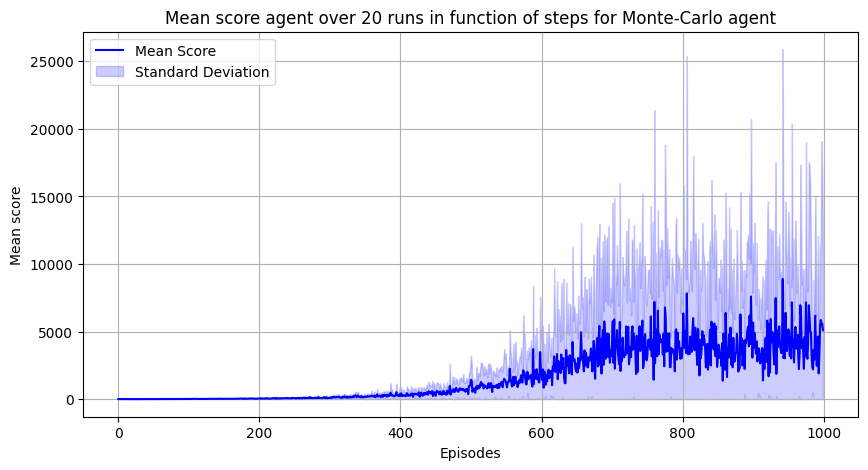

In [ ]:
agent = MonteCarloAgent(env, validate_model=False)
plot_avg_score(env, agent_class=MonteCarloAgent, name_agent='Monte-Carlo', num_episodes=1000, num_runs=20)

### Monte Carlo State-Value function plots

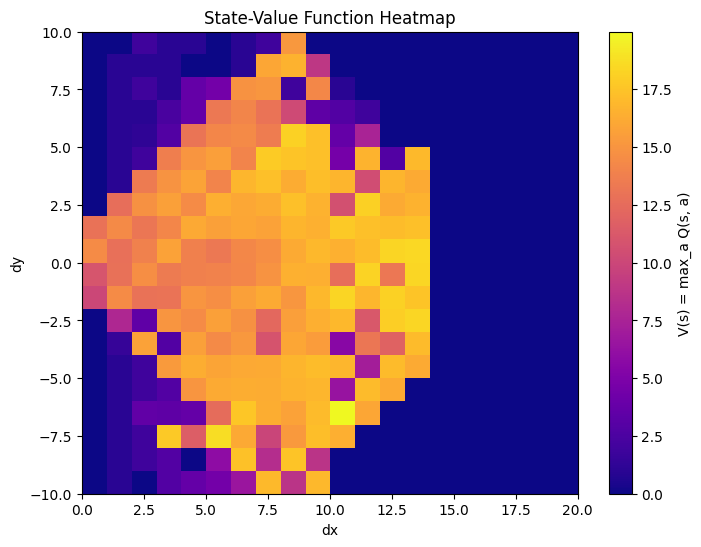

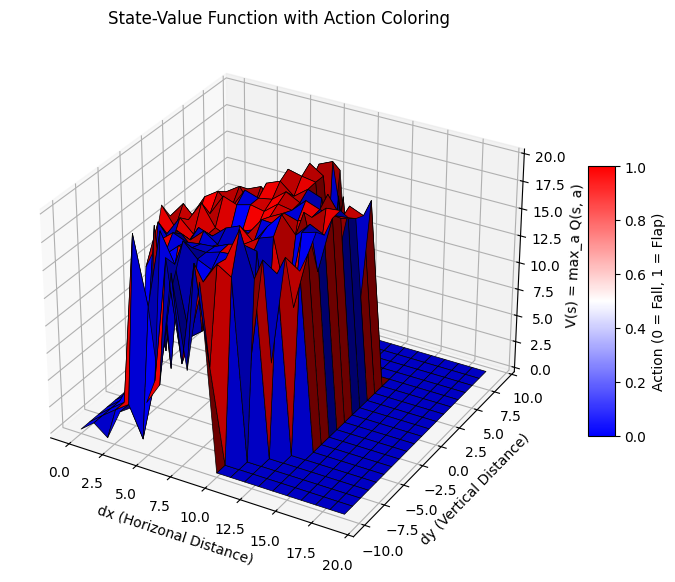

In [ ]:
plot_state_value(agent_mc)
plot_state_action(agent_mc)

The state value plots show Q tables that seem logical, the more we get close to the pipe gap, the more high value states are concentrated at the horizontal center. The agent learns to maximize its state value by remaining vertically centered while approaching the next obstacle.

### SARSA averaged score over 20 runs

Runs:   0%|          | 0/20 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

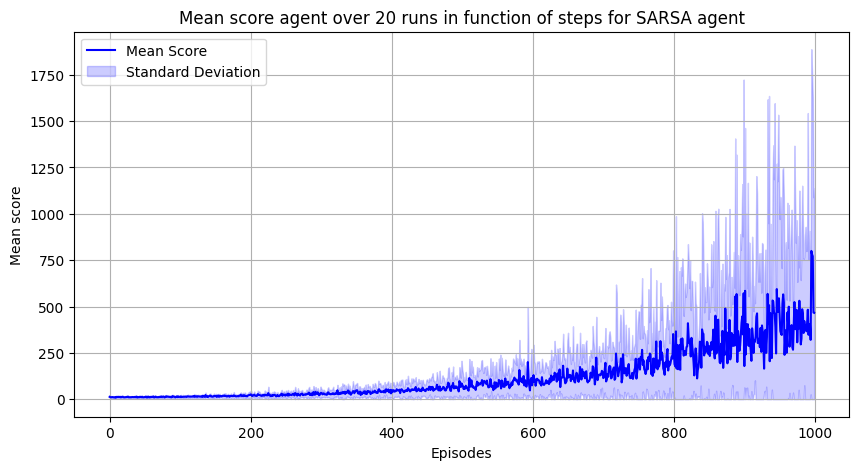

In [ ]:
agent = SarsaAgent(env, validate_model=False)
plot_avg_score(env, agent_class=SarsaAgent, name_agent='SARSA', num_episodes=1000, num_runs=20)

### SARSA State-Value function plots

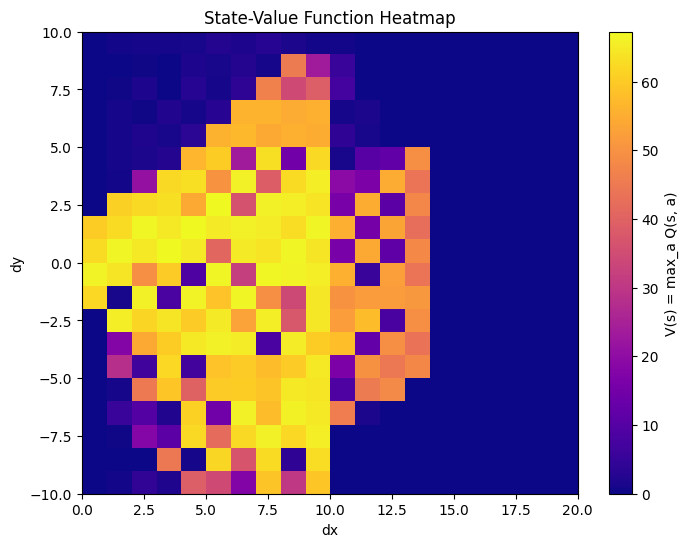

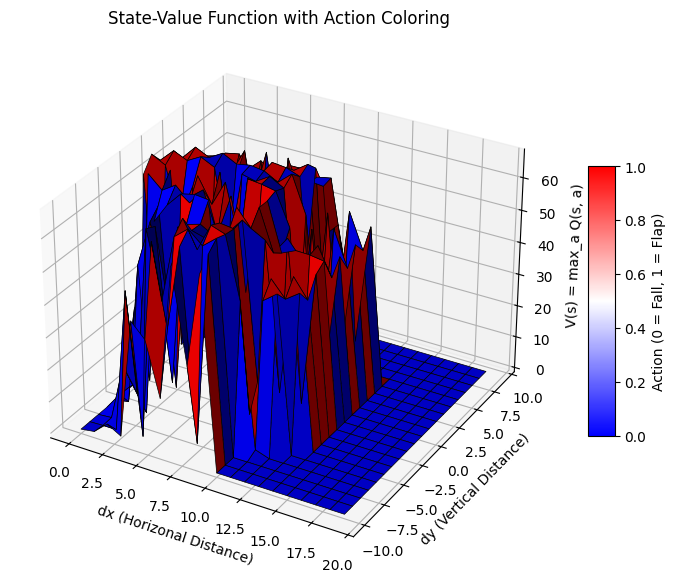

In [ ]:
plot_state_value(agent_sarsa)
plot_state_action(agent_sarsa)

The state-value functions of the 2 agents remain very similar in terms of shape. This tells us that whatever method is used, the 2 agents both manage to learn an optimal Q table for action selection.

## Param sweep 

In this part we try to evaluate the influence of core hyperparamters such as epsilon decay and gamma, which common to the 2 agents.

### Influence of gamma on averaged scores

Gamma : 0.9, Espilon decay : 0.99


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Gamma : 0.95, Espilon decay : 0.99


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Gamma : 0.99, Espilon decay : 0.99


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

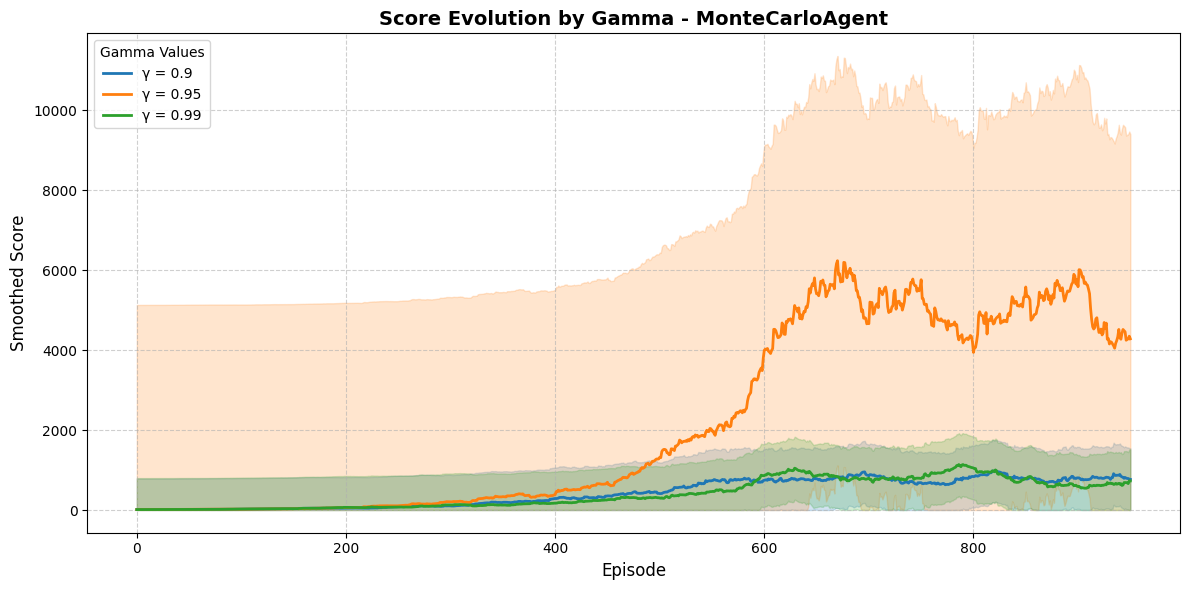

In [ ]:
plot_scores_by_gamma(env,agent_class=MonteCarloAgent, gamma_values=[0.9, 0.95, 0.99], num_episodes=1000)

Gamma : 0.9, Espilon decay : 0.995


Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Gamma : 0.95, Espilon decay : 0.995


Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Gamma : 0.99, Espilon decay : 0.995


Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

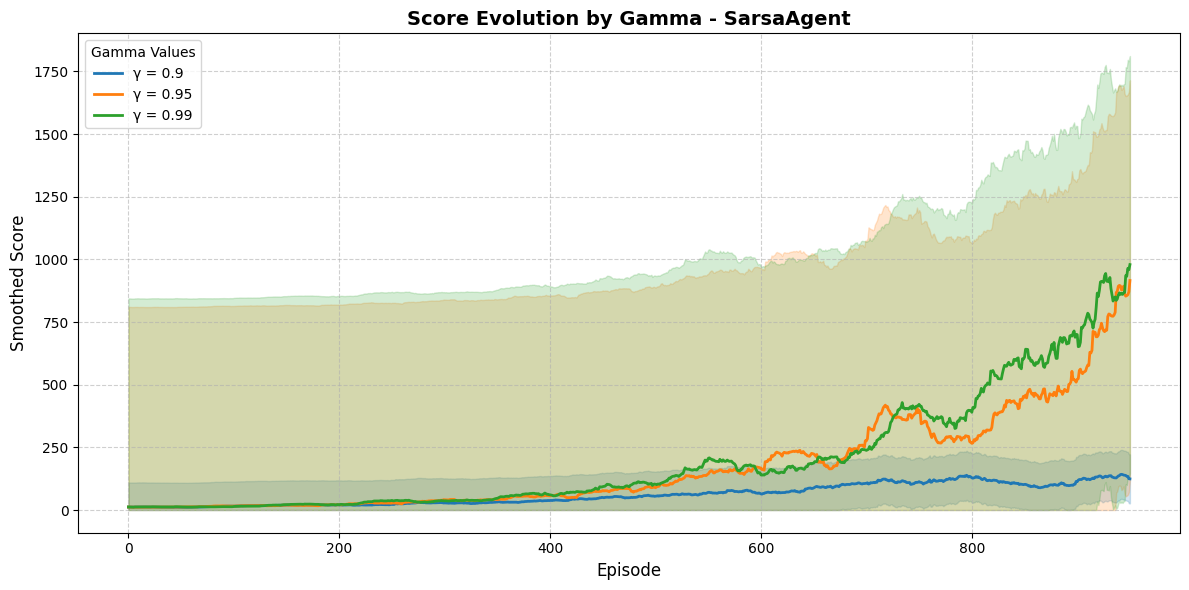

In [ ]:
plot_scores_by_gamma(env,agent_class=SarsaAgent, gamma_values=[0.9, 0.95, 0.99], num_episodes=1000)

### Influence of epsilon decay on averaged scores

Gamma : 0.95, Espilon decay : 0.98


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Gamma : 0.95, Espilon decay : 0.99


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Gamma : 0.95, Espilon decay : 0.995


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Gamma : 0.95, Espilon decay : 0.997


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Gamma : 0.95, Espilon decay : 0.999


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

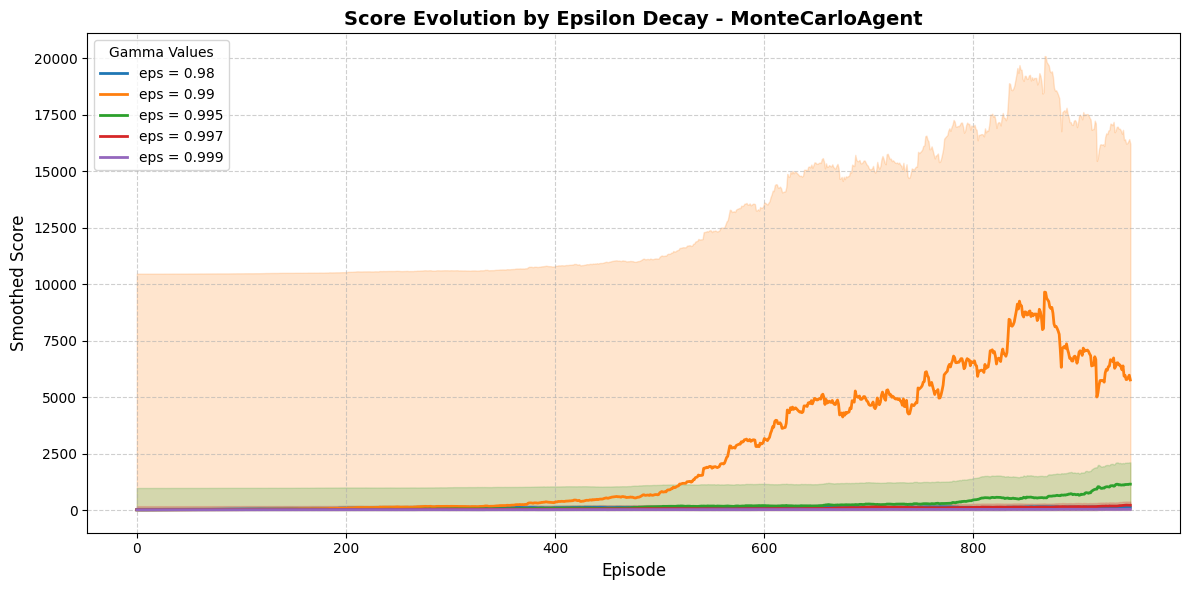

In [ ]:
plot_scores_by_eps_decay(env, agent_class=MonteCarloAgent, eps_decay_values=[0.98, 0.99, 0.995, 0.997, 0.999], num_episodes=1000)

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

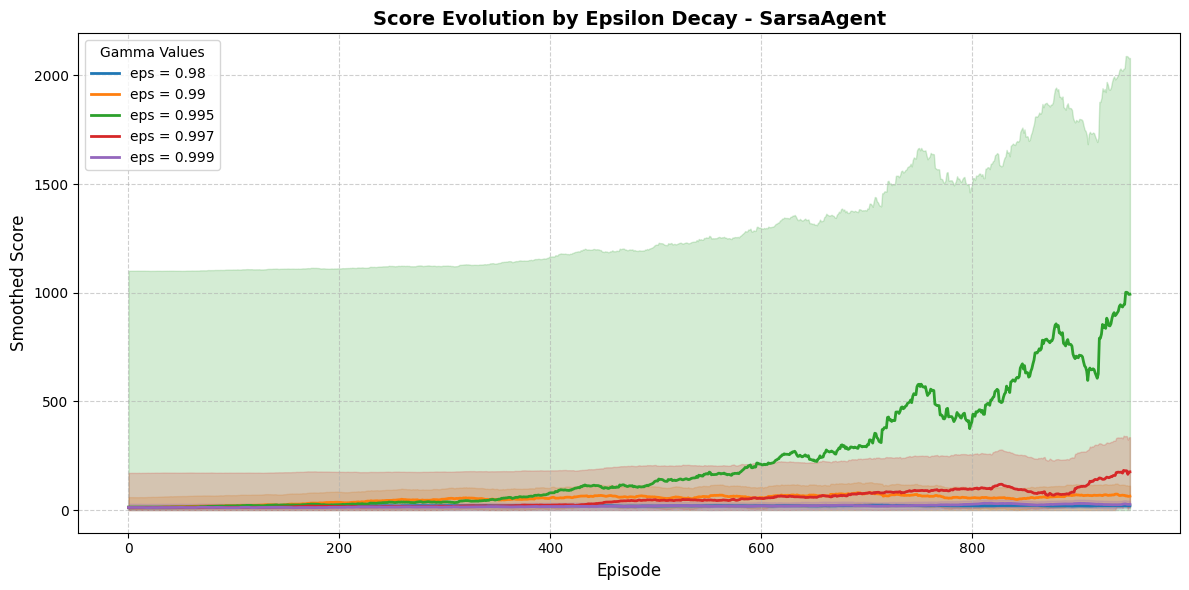

In [ ]:
plot_scores_by_eps_decay(env, agent_class=SarsaAgent, eps_decay_values=[0.98, 0.99, 0.995, 0.997, 0.999], num_episodes=1000)

The influence of the gamma and epsilon decay parameters is quite obvious. 
In the case of Monte Carlo, the best performances are obtained with $\gamma = 0.95$ and $\epsilon_{decay} = 0.99$, showing a preference for prolonged exploration. 
SARSA, on the other hand, achieves better scores with $\gamma = 0.99$ and $\epsilon_{decay} = 0.995$, relying on longer-term rewards.

## Comparing environments

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Training SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

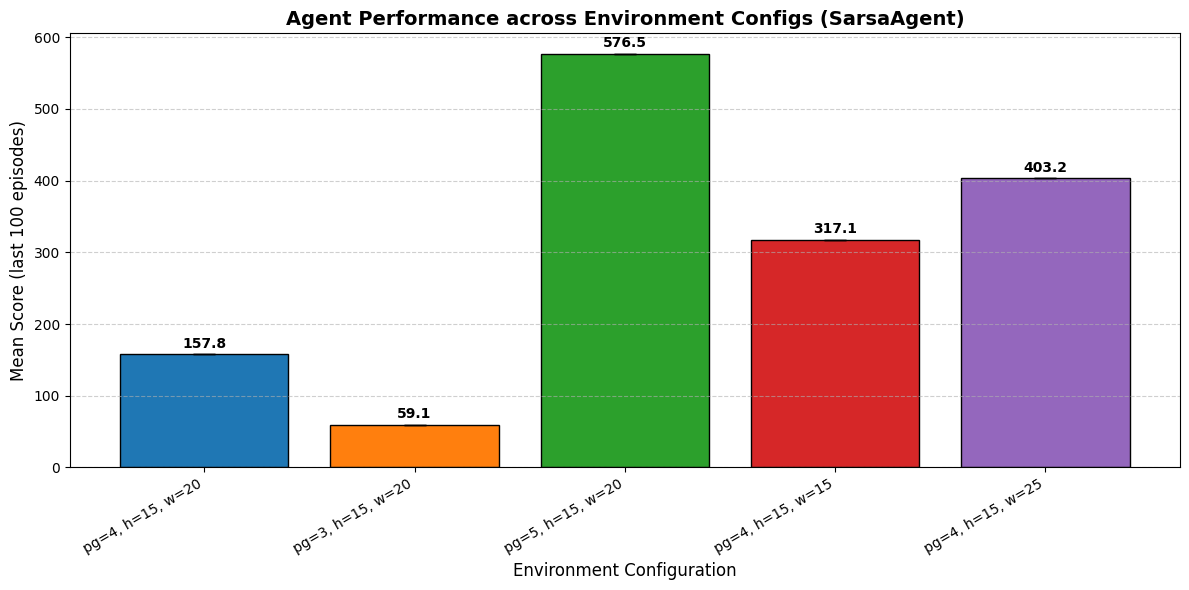

In [ ]:
configs = [
    {"pipe_gap": 4, "height": 15, "width": 20},  # Original one
    {"pipe_gap": 3, "height": 15, "width": 20},
    {"pipe_gap": 5, "height": 15, "width": 20},
    {"pipe_gap": 4, "height": 15, "width": 15},
    {"pipe_gap": 4, "height": 15, "width": 25}]


results = plot_scores_by_env_configs(SarsaAgent, configs, num_episodes=1000, n_runs=1)

Unsurprisingly, compared with the base configuration <em>pipe gap=4, h=15, w=20</em>, the agent performs better when the pipe gap is large, with a mean score of 576 versus only 157 for the base configuration. What's more, the agent also performs better with a wider gap (mean score of 403), as the environment is wider and the agent can anticipate better.